In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

In [2]:
!ls ../data

ChCh-Miner_durgbank-chem-chem.tsv       PP-Decagon_ppi.csv.gz
ChCh-Miner_durgbank-chem-chem.tsv.gz    PP-Pathways_ppi.csv.gz
ChChSe-Decagon_polypharmacy.csv         all_drugs.pickle
ChChSe-Decagon_polypharmacy.csv.gz      bio-decagon-combo.csv
ChG-InterDecagon_targets.csv.gz         bio-decagon-combo.tar.gz
ChG-Miner_miner-chem-gene.tsv           bio-decagon-effectcategories.csv
ChG-Miner_miner-chem-gene.tsv.gz        bio-decagon-effectcategories.tar.gz
ChG-TargetDecagon_targets (1).csv.gz    bio-decagon-mono.csv
ChG-TargetDecagon_targets (2).csv.gz    bio-decagon-mono.tar.gz
ChG-TargetDecagon_targets.csv.gz        bio-decagon-ppi.csv
D-DoMiner_miner-diseaseDOID-entity.tsv  bio-decagon-ppi.tar.gz
D-DoMiner_miner-diseaseDOID.tsv.gz      bio-decagon-targets.csv
D-MeshMiner_miner-disease-entity.tsv    bio-decagon-targets.tar.gz
D-MeshMiner_miner-disease-entity.tsv.gz ddinter_downloads_code_V.csv
DCh-Miner_miner-disease-chemical.tsv    drug_similarity_reduced.csv
DD-Miner_miner-disease-dis

In [6]:
# MID = '# Disease MESH_ID'
# df_disease_drug = pd.read_csv('../data/DCh-Miner_miner-disease-chemical.tsv', sep='\t').rename(
#     columns={'# Disease(MESH)': '# Disease MESH_ID', 'Chemical': 'chemical'}
# )
# df_disease_entity = pd.read_csv('../data/D-MeshMiner_miner-disease-entity.tsv', sep='\t').rename(
#     columns={'# MESH_ID': '# Disease MESH_ID'}
# )
# df_drug_drug = pd.read_csv('../data/ChCh-Miner_durgbank-chem-chem.tsv', sep='\t', names=['chemical_a', 'chemical_b'])
# df_disease_disease = pd.read_csv('../data/DD-Miner_miner-disease-disease.tsv', sep='\t').rename(
#     columns={}
# )
# df_ddd = pd.read_csv('../data/bio-decagon-effectcategories.csv')

se_label = 'Individual Side Effect'
df_dd = pd.read_csv('../data/bio-decagon-combo.csv')
df_dd = df_dd.drop_duplicates(subset=['STITCH 1', 'STITCH 2'], keep='first').rename(
    columns={'STITCH 1': 'drug_1', 'STITCH 2': 'drug_2'})
df_pp = pd.read_csv('../data/bio-decagon-ppi.csv').rename(columns={'Gene 1': 'gene_1', 'Gene 2': 'gene_2'})
df_dt = pd.read_csv('../data/bio-decagon-targets.csv').rename(columns={'STITCH': 'drug', 'Gene': 'gene'})
df_dt = df_dt.rename(columns={'drug': 'STITCH'})
df_ds = pd.read_csv('../data/bio-decagon-mono.csv') # drug - side-effect
df = pd.read_csv('../data/drugbank.txt', sep='\t')
df = df.drop_duplicates(subset=['DrugbankID', 'CID'], keep='first')
df_dsim = pd.read_csv('../data/similarity.csv', index_col=0)

did_to_cid = {row.DrugbankID: row.CID for _, row in df[['DrugbankID', 'CID']].iterrows() if not pd.isnull(row.CID)}
cid_to_did = {row.CID: row.DrugbankID for _, row in df[['DrugbankID', 'CID']].iterrows() if not pd.isnull(row.CID)}

df_ds['compound'] = df_ds.STITCH.apply(lambda x: cid_to_did.get(x, None))
df_dt['compound'] = df_dt.STITCH.apply(lambda x: cid_to_did.get(x, None))

df_dsim['STITCH0'] = df_dsim.compound0.apply(lambda x: did_to_cid.get(x, None))
df_dsim['STITCH1'] = df_dsim.compound1.apply(lambda x: did_to_cid.get(x, None))

se_idx_mapper = {se: i for i, se in enumerate(all_se)}
df_ds['se_idx'] = df_ds[se_label].apply(lambda x: se_idx_mapper[x])

,DrugbankID,UniprotID,HGNC_ID,HGNC_Name,CID,CHEMBL,Entrez_ID,Entrez_Gene,Unnamed: 8,Unnamed: 9
0,DB00102,P01023,HGNC:7,A2M,NaN,NaN,2,A2M,NaN,NaN
1,DB00626,P01023,HGNC:7,A2M,CID000439542,NaN,2,A2M,NaN,NaN
2,DB08888,P01023,HGNC:7,A2M,NaN,NaN,2,A2M,NaN,NaN
3,DB00160,P49588,HGNC:20,AARS,CID000005950,CHEMBL279597,16,AARS,NaN,NaN
5,DB00119,P80404,HGNC:23,ABAT,CID000001060,CHEMBL1162144,18,ABAT,NaN,NaN


In [468]:

all_drugs = list(set(df_ds.STITCH.unique().tolist()).union(df_dt.STITCH.unique()))
all_targets = list(set(df_dt.gene.tolist()))
n_drugs = len(all_drugs)
n_targets = len(all_targets)
pp_idx_mapper = {p: all_targets.index(p) for p in all_targets}
all_se = list(df_ds[se_label].unique())
all_drugs_did = list(set(df_ds.compound.unique().tolist()).union(df_dt.compound.unique()))

In [138]:
# select only drugs that has similarity (only removed 1)
all_drugs = list(set(df_dsim['STITCH0'].unique()).union(set(df_dsim['STITCH1'].unique())))
all_drugs_did = [cid_to_did[d] for d in all_drugs]

In [93]:
import pickle

with open('../data/all_drugs_did.pickle', 'wb') as f:
    pickle.dump(all_drugs_did, f)


In [9]:
from typing import Set

def jaccard(s1: Set, s2: Set):
    return len(s1.intersection(s2))/len((s1.union(s2)))

jaccard({1,2,3,4}, {1,2})

0.5

## EDA -ish

In [440]:
def visualize_graph(df, col1, col2, n=1000):
    poi = df_ds[['STITCH', 'Individual Side Effect']].head(n)
    Gp = nx.Graph()
    Gp.add_edges_from(list(poi.itertuples(index=False, name=None)))
    nx.draw(Gp, node_size=2, node_color= ['red' if node.startswith('CID') else 'blue' for node in Gp.nodes])

In [385]:
def visualize_dt(df=df_dt, col1='gene', col2='STITCH', n=1000):
    poi = df[[col1, col2]].head(n)
#     print(poi)
    Gp = nx.Graph()
    Gp.add_edges_from(list(poi.itertuples(index=False, name=None)))
    nx.draw(Gp, node_size=2, node_color= ['red' if type(node)==int else 'blue' for node in Gp.nodes])


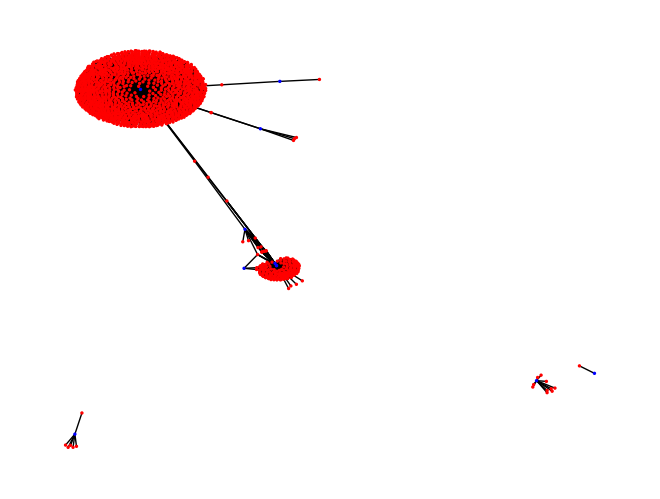

In [387]:
visualize_dt(df_dt, n=2000)

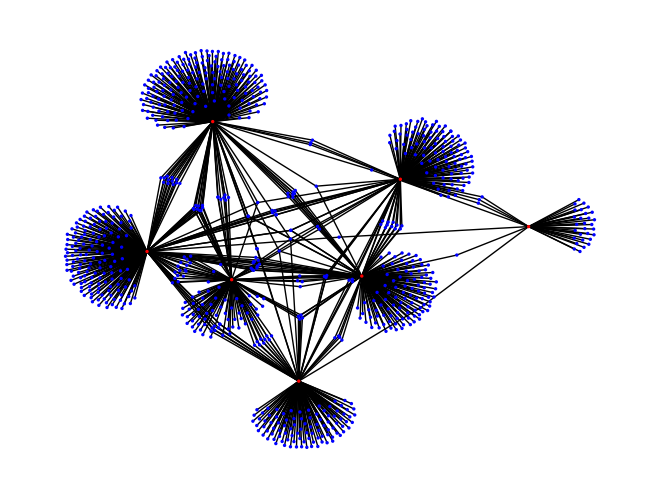

In [130]:
visualize_graph(df_ds, 'STITCH', 'Individual Side Effect', 1000)

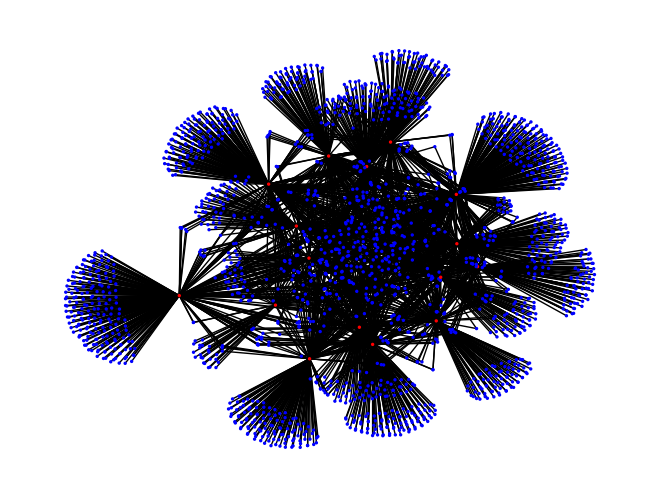

In [358]:
visualize_graph(df_ds, 'STITCH', 'Individual Side Effect', 3000)

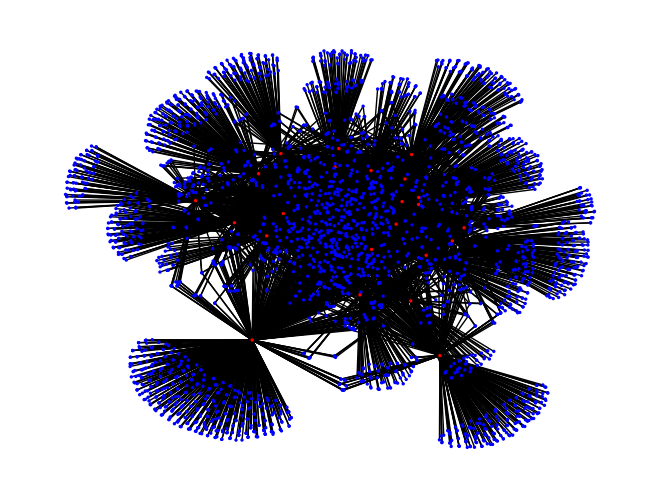

In [441]:
visualize_graph(df_ds, 'STITCH', 'Individual Side Effect', 5000)

In [ ]:
visualize_graph(df_ds, 'STITCH', 'Individual Side Effect', 2000)

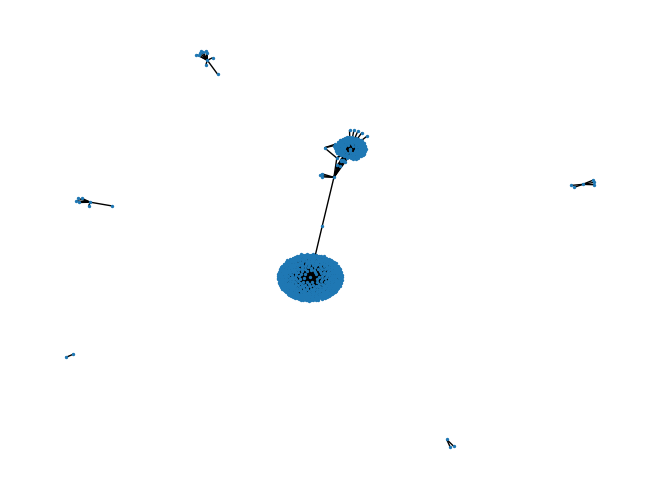

In [25]:
import networkx as nx
Gp = nx.Graph()
Gp.add_edges_from(list(df_dt[['drug', 'gene']].head(1000).itertuples(index=False, name=None)))
nx.draw(Gp, node_size=2)

In [ ]:
class DSERandomWalk:
    def __init__(df_ds, df_dsim, df_dt):
        self.df_ds = df_ds
        self.df_dsim = df_dsim
        self.df_dt = df_Dt
        self.all_drugs = list(set(df_ds.STITCH.unique().tolist()).union(df_dt.STITCH.unique()))
        self.all_targets = list(set(df_dt.gene.tolist()))
        self.n_drugs = len(all_drugs)
        self.n_targets = len(all_targets)
        self.all_se = list(df_ds[se_label].unique())
        all_drugs_did = list(set(df_ds.compound.unique().tolist()).union(df_dt.compound.unique()))
    
    def dd_chem_similarity_matrix(all_drugs=all_drugs, df_sim=df_dsim):
        """Drug-Drug similarity matrix based on chemical structures"""
        n = len(all_drugs)
        M = np.zeros((n, n), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n-1)):
            d1 = all_drugs[i]
            poi = df_sim[(df_sim.STITCH0==d1)|(df_sim.STITCH1==d1)]
            if not poi.shape[0]:
                continue
            for j in range(i+1, n):
                d2 = all_drugs[j]
                ss = poi[(poi.STITCH0==d2)|(poi.STITCH1==d2)]
                if ss.shape[0]:
                    s = ss.iloc[0].similarity
                    M[i, j] = s
                    M[j, i] = s

        # normalize
        norm_terms = np.sum(M, axis=1)
        norm_terms[np.where(norm_terms == 0)] = 1
        D = np.diag(norm_terms)
        D_sq = fractional_matrix_power(D, -1/2)
        S = np.matmul(np.matmul(D_sq, M), D_sq)

        return S

    def dd_target_similarity_matrix(df_dt, all_drugs=all_drugs):
        """Drug-Drug similarity based on shared targets"""
        n = len(all_drugs)
        M = np.zeros((n, n), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n-1)):
            d1 = all_drugs[i]
            targets_i = set(df_dt[df_dt.STITCH==d1].gene)
            if not len(targets_i):
                continue
            for j in range(i+1, n):
                d2 = all_drugs[j]
                targets_j = set(df_dt[df_dt.STITCH==d2].gene)
                if not len(targets_i):
                    continue
                jc = jaccard(targets_i, targets_j)
                M[i, j] = jc
                M[j, i] = jc
        norm_terms = np.sum(M, axis=1)  
        norm_terms[np.where(norm_terms == 0)] = 1
        D = np.diag(norm_terms)
        D_sq = fractional_matrix_power(D, -1/2)
        S = np.matmul(np.matmul(D_sq, M), D_sq)
        return S
        
    def ss_similarity_matrix(df=df_ds, all_se=all_se):
        """Side Effect-Side Effect similarity based on shared drugs"""
        n = len(all_se)
        M = np.zeros((n, n), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n-1)):
            se1 = all_se[i]
            drugs_i = set(df[df[se_label]==se1].STITCH)
            if not len(drugs_i):
                continue
            for j in range(i+1, n):
                se2 = all_se[j]
                drugs_j = set(df[df[se_label]==se2].STITCH)
                if not len(drugs_i):
                    continue
                jc = jaccard(drugs_i, drugs_j)
                M[i, j] = jc
                M[j, i] = jc
        norm_terms = np.sum(M, axis=1)  
        norm_terms[np.where(norm_terms == 0)] = 1
        D = np.diag(norm_terms)
        D_sq = fractional_matrix_power(D, -1/2)
        S = np.matmul(np.matmul(D_sq, M), D_sq)
        return S
    
    def dd_transition_matrix(df, all_drugs=all_drugs):
        """Drug-Drug transition matrix"""
        A = np.zeros((n_drugs, n_drugs), dtype=np.float32)
        adj_lst = []
        for i, d1 in enumerate(all_drugs):
            nbrs1 = df[df['drug_1_id']==i].drug_2_id.unique().tolist()
            nbrs2 = df[df['drug_2_id']==i].drug_1_id.unique().tolist()
            for j in nbrs1 + nbrs2:
                A[i, j] = 1
                A[j, i] = 1
        return A
    
    def ds_transition_matrix(df=df_ds, all_drugs=all_drugs, all_se=all_se, A=A_ds):
        """Drug-Side Effect transition matrix"""
        n_drugs = len(all_drugs)
        n_se = len(all_se)
        M = np.zeros((n_drugs, n_se), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n_drugs)):
            n_nbrs = np.sum(A[i])
            if not n_nbrs:
                continue
            for j in range(n_se):
                M[i,j] = A[i, j]/n_nbrs
        return M
    
    def sd_transition_matrix(df=df_ds, all_drugs=all_drugs, all_se=all_se, A=A_ds):
        """Side Effect-Drug transition matrix"""
        n_drugs = len(all_drugs)
        n_se = len(all_se)
        M = np.zeros((n_se, n_drugs), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n_se)):
            n_nbrs = np.sum(A[:,i])
            if not n_nbrs:
                continue
            for j in range(n_drugs):
                M[i,j] = A[j, i]/n_nbrs
        return M
    
    
    

## SE-SE Network

Number of shared drugs among pairs of SE

(array([ 84., 139., 111.,  41.,  27.,  13.,  11.,   4.,   3.,   2.]),
 array([ 1. ,  9.9, 18.8, 27.7, 36.6, 45.5, 54.4, 63.3, 72.2, 81.1, 90. ]),
 <BarContainer object of 10 artists>)

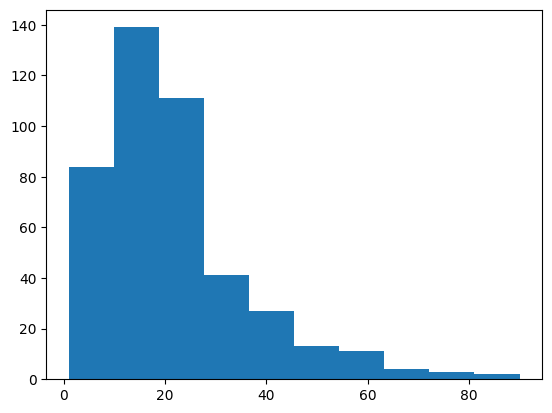

In [383]:
ss = df_ds.STITCH.unique()
hs = []
for i in range(30-1):
    s1 = set(df_ds[df_ds.STITCH==ss[i]]['Individual Side Effect'].unique())
    for j in range(i+1, 30):
        s2 = set(df_ds[df_ds.STITCH==ss[j]]['Individual Side Effect'].unique())
        hs.append(len(s1.intersection(s2)))

    
plt.hist(hs)

In [427]:
df_ds.head()

,STITCH,Individual Side Effect,Side Effect Name,compound
0,CID003062316,C1096328,central nervous system mass,DB01254
1,CID003062316,C0162830,Photosensitivity reaction,DB01254
2,CID003062316,C1611725,leukaemic infiltration brain,DB01254
3,CID003062316,C0541767,platelet adhesiveness abnormal,DB01254
4,CID003062316,C0242973,Ventricular dysfunction,DB01254


In [431]:
def ss_similarity_matrix(df=df_ds, all_se=all_se):
    """Similarity based on shared drugs"""
    n = len(all_se)
    M = np.zeros((n, n), dtype=np.float32)
    adj_lst = []
    for i in tqdm(range(n-1)):
        se1 = all_se[i]
        drugs_i = set(df[df[se_label]==se1].STITCH)
        if not len(drugs_i):
            continue
        for j in range(i+1, n):
            se2 = all_se[j]
            drugs_j = set(df[df[se_label]==se2].STITCH)
            if not len(drugs_i):
                continue
            jc = jaccard(drugs_i, drugs_j)
            M[i, j] = jc
            M[j, i] = jc
    norm_terms = np.sum(M, axis=1)  
    norm_terms[np.where(norm_terms == 0)] = 1
    D = np.diag(norm_terms)
    D_sq = fractional_matrix_power(D, -1/2)
    S = np.matmul(np.matmul(D_sq, M), D_sq)
    return S

In [488]:
S = ss_similarity_matrix(all_se=all_se[:5])
S

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.98it/s]


array([[0.        , 0.0765553 , 0.33472803, 0.22426753, 0.42897806],
       [0.0765553 , 0.        , 0.0765553 , 0.0943301 , 0.1456195 ],
       [0.33472803, 0.0765553 , 0.        , 0.22426753, 0.42897806],
       [0.22426753, 0.09433009, 0.22426753, 0.        , 0.2395125 ],
       [0.4289781 , 0.1456195 , 0.4289781 , 0.23951249, 0.        ]],
      dtype=float32)

In [ ]:
def ds_transition_matrix(df=df_ds, all_drugs=all_drugs, all_se=all_se, A=A_ds):
    """Drug-Side Effect transition matrix"""
    n_drugs = len(all_drugs)
    n_se = len(all_se)
    M = np.zeros((n_drugs, n_se), dtype=np.float32)
    adj_lst = []
    for i in tqdm(range(n_drugs)):
        n_nbrs = np.sum(A[i])
        if not n_nbrs:
            continue
        for j in range(n_se):
            M[i,j] = A[i, j]/n_nbrs
    return M

In [498]:
def ss_transition_matrix(S_ss, A_ds, lmd):
    norm = np.sum(S_ss, axis=1)
    row_sum_A_sd = np.sum(A_ds, axis=0)
    M = np.zeros_like(S_ss)
    for i in range(S_ss.shape[0]):
        if row_sum_A_sd[i]:
            M[i] = S_ss[i]/norm[i] * (1-lmd)
        else:
            M[i] = S_ss[i]/norm[i]
    return M
    
def ds_adj_matrix(df=df_ds, all_se=all_se, all_drugs=all_drugs): #row: drugs, col: targets
    n_drugs = len(all_drugs)
    n_se = len(all_se) 
    A = np.zeros((n_drugs, n_se), dtype=np.float32)
    adj_lst = []
    for i in tqdm(range(n_drugs)):
        nbrs = df[df.STITCH==all_drugs[i]].se_idx.unique()
        nbrs = df[df.STITCH==all_drugs[i]][se_label]
        # TODO: fix below line
        nbrs = [all_se.index(nb) for nb in nbrs if nb in all_drugs]
        for j in nbrs:
            A[i, j] = 1
    return A

In [499]:
S_ss = ss_similarity_matrix(df_ds, all_se[:10])
A_ds = ds_adj_matrix(all_se=all_se[:10], all_drugs=all_drugs[:10])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.22it/s]


In [501]:
np.sum(ss_transition_matrix(S_ss, A_ds, 0.5), axis=1)

array([1.        , 1.        , 1.0000001 , 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ],
      dtype=float32)

In [479]:
a = np.array([
    [1,2,3],
    [2,2,2]
])
b = np.sum(a, axis=1)

In [481]:
a[0]/b[0]

array([0.16666667, 0.33333333, 0.5       ])

In [437]:
len(all_se)

10184

In [436]:
S_ss = ss_similarity_matrix(df_ds, all_se[:10])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.87it/s]


### Drug Similarity  Matrix $S_{dd}^{t}, S_{dd}^{c}$

In [422]:
from tqdm import tqdm
from scipy.linalg import sqrtm
from scipy.linalg import fractional_matrix_power

def dd_chem_similarity_matrix(all_drugs=all_drugs, df_sim=df_dsim):
    """Similarity based on chemical structures"""
    n = len(all_drugs)
    M = np.zeros((n, n), dtype=np.float32)
    adj_lst = []
    for i in tqdm(range(n-1)):
        d1 = all_drugs[i]
        poi = df_sim[(df_sim.STITCH0==d1)|(df_sim.STITCH1==d1)]
        if not poi.shape[0]:
            continue
        for j in range(i+1, n):
            d2 = all_drugs[j]
            ss = poi[(poi.STITCH0==d2)|(poi.STITCH1==d2)]
            if ss.shape[0]:
                s = ss.iloc[0].similarity
                M[i, j] = s
                M[j, i] = s

    # normalize
    norm_terms = np.sum(M, axis=1)
    norm_terms[np.where(norm_terms == 0)] = 1
    D = np.diag(norm_terms)
    D_sq = fractional_matrix_power(D, -1/2)
    S = np.matmul(np.matmul(D_sq, M), D_sq)
    
    return S

def dd_target_similarity_matrix(df_dt, all_drugs=all_drugs):
    """Similarity based on shared targets"""
    n = len(all_drugs)
    M = np.zeros((n, n), dtype=np.float32)
    adj_lst = []
    for i in tqdm(range(n-1)):
        d1 = all_drugs[i]
        targets_i = set(df_dt[df_dt.STITCH==d1].gene)
        if not len(targets_i):
            continue
        for j in range(i+1, n):
            d2 = all_drugs[j]
            targets_j = set(df_dt[df_dt.STITCH==d2].gene)
            if not len(targets_i):
                continue
            jc = jaccard(targets_i, targets_j)
            M[i, j] = jc
            M[j, i] = jc
    norm_terms = np.sum(M, axis=1)  
    norm_terms[np.where(norm_terms == 0)] = 1
    D = np.diag(norm_terms)
    D_sq = fractional_matrix_power(D, -1/2)
    S = np.matmul(np.matmul(D_sq, M), D_sq)
    return S


In [423]:
S_ts = dd_target_similarity_matrix(df_dt, all_drugs[:10])
S_ch = dd_chem_similarity_matrix(all_drugs=all_drugs[:10], df_sim=df_dsim)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 34.11it/s]


### Drug Similarity Matrix (combined) $S_{dd}$

In [475]:
w_d = 0.5
S_dd = w_d*S_ch + (1-w_d)*S_ts

In [502]:
def dd_transition_matrix(S_d, A_ds, lmd=0.5):
    norm = np.sum(S_d, axis=1)
    row_sum_A_ds = np.sum(A_ds, axis=1)
    
    M = np.zeros_like(S_d)
    for i in range(S_d.shape[0]):
        if row_sum_A_ds[i]:
            M[i] = S_d[i]/norm[i] * (1-lmd)
        else:
            M[i] = S_d[i]/norm[i]
    return M

In [506]:
M_dd = dd_transition_matrix(S_dd, A_ds, lmd=0.5)
np.sum(M_dd, axis=1)

array([0.99999994, 1.        , 0.99999994, 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ],
      dtype=float32)

### Drug-Drug Transition Matrix $M_{DD}$

In [41]:
def dd_transition_matrix(df, all_drugs=all_drugs):
    A = np.zeros((n_drugs, n_drugs), dtype=np.float32)
    adj_lst = []
    for i, d1 in enumerate(all_drugs):
        nbrs1 = df[df['drug_1_id']==i].drug_2_id.unique().tolist()
        nbrs2 = df[df['drug_2_id']==i].drug_1_id.unique().tolist()
        for j in nbrs1 + nbrs2:
            A[i, j] = 1
            A[j, i] = 1
    return A

### Drug-Side Effects Transition Matrix $M_{DS}$

In [332]:
all_se = list(df_ds['Individual Side Effect'].unique())
se_idx_mapper = {se: all_se.index(se) for se in all_se}
df_ds['se_idx'] = df_ds['Individual Side Effect'].apply(lambda x: se_idx_mapper[x])

In [333]:
df_ds.head()

,STITCH,Individual Side Effect,Side Effect Name,se_idx
0,CID003062316,C1096328,central nervous system mass,0
1,CID003062316,C0162830,Photosensitivity reaction,1
2,CID003062316,C1611725,leukaemic infiltration brain,2
3,CID003062316,C0541767,platelet adhesiveness abnormal,3
4,CID003062316,C0242973,Ventricular dysfunction,4


In [448]:
df_ds

,STITCH,Individual Side Effect,Side Effect Name,compound
0,CID003062316,C1096328,central nervous system mass,DB01254
1,CID003062316,C0162830,Photosensitivity reaction,DB01254
2,CID003062316,C1611725,leukaemic infiltration brain,DB01254
3,CID003062316,C0541767,platelet adhesiveness abnormal,DB01254
4,CID003062316,C0242973,Ventricular dysfunction,DB01254
...,...,...,...,...
174972,CID005282226,C1096278,anterior chamber inflammation,DB00287
174973,CID005282226,C0272412,splenic abscess,DB00287
174974,CID005282226,C0860013,hepatitis b antibody positive,DB00287
174975,CID005282226,C0853225,international normalised ratio increased,DB00287


In [450]:
se_idx_mapper = {se: i for i, se in enumerate(all_se)}

In [451]:
se_idx_mapper = {se: i for i, se in enumerate(all_se)}
df_ds['se_idx'] = df_ds[se_label].apply(lambda x: se_idx_mapper[x])

In [465]:
def ds_adj_matrix(df=df_ds, all_se=all_se, all_drugs=all_drugs): #row: drugs, col: targets
    n_drugs = len(all_drugs)
    n_se = len(all_se) 
    A = np.zeros((n_drugs, n_se), dtype=np.float32)
    adj_lst = []
    for i in tqdm(range(n_drugs)):
        nbrs = df[df.STITCH==all_drugs[i]].se_idx.unique()
        nbrs = df[df.STITCH==all_drugs[i]][se_label]
        nbrs = [all_se.index(nb) for nb in nbrs]
        for j in nbrs:
            A[i, j] = 1
    return A

In [470]:
A_ds = ds_adj_matrix(df=df_ds, all_drugs=all_drugs[:10])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 24.78it/s]


In [471]:
A_ds

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [457]:
def ds_transition_matrix(df=df_ds, all_drugs=all_drugs, all_se=all_se, A=A_ds):
    n_drugs = len(all_drugs)
    n_se = len(all_se)
    M = np.zeros((n_drugs, n_se), dtype=np.float32)
    adj_lst = []
    for i in tqdm(range(n_drugs)):
        n_nbrs = np.sum(A[i])
        if not n_nbrs:
            continue
        for j in range(n_se):
            M[i,j] = A[i, j]/n_nbrs
    return M

In [472]:
M_ds = ds_transition_matrix(df=df_ds, all_drugs=all_drugs[:10], all_se=all_se, A=A_ds)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 114.77it/s]


In [474]:
np.sum(M_ds, axis=1)

array([0.99999994, 1.        , 1.        , 0.9999999 , 0.99999994,
       1.        , 1.0000001 , 1.        , 1.        , 1.        ],
      dtype=float32)

### Side Effects-Drugs Transition Matrix  $𝑀_{SD}$

In [456]:
def sd_transition_matrix(df=df_ds, all_drugs=all_drugs, all_se=all_se, A=A_ds):
    n_drugs = len(all_drugs)
    n_se = len(all_se)
    M = np.zeros((n_se, n_drugs), dtype=np.float32)
    adj_lst = []
    for i in tqdm(range(n_se)):
        n_nbrs = np.sum(A[:,i])
        if not n_nbrs:
            continue
        for j in range(n_drugs):
            M[i,j] = A[j, i]/n_nbrs
    return M

In [44]:
A_dd = dd_adj_matrix(df_dd, all_drugs=all_drugs)
A_dd

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 0., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 0., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.]], dtype=float32)

In [31]:
np.ones(1).dtype

dtype('float64')

In [325]:
df_poly_drug['# STITCH 1'].unique().shape

(616,)

In [322]:
df_poly_drug[df_poly_drug["# STITCH 1"]=='CID000002173']['Side Effect Name'].unique().shape

(478,)

In [318]:
df_poly_drug['Polypharmacy Side Effect'].unique().shape

(1317,)

In [350]:
len(set(df_poly_drug['# STITCH 1'].unique()).union(set(df_poly_drug['STITCH 2'].unique())))
#.shape

645

In [347]:
df_poly_drug['STITCH 2'].unique().shape

(634,)

In [351]:
645*645

416025

In [352]:
df_poly_drug.drop_duplicates(subset=['# STITCH 1', 'STITCH 2'], keep='first')

,# STITCH 1,STITCH 2,Polypharmacy Side Effect,Side Effect Name
0,CID000002173,CID000003345,C0151714,hypermagnesemia
56,CID000005206,CID000009433,C0040034,thrombocytopenia
68,CID000003929,CID000150610,C0015230,eruption
92,CID000001302,CID000005064,C0004601,back injury
226,CID000005267,CID000010631,C0043096,loss of weight
...,...,...,...,...
4649065,CID000004889,CID000060754,C0151908,dry skin
4649085,CID000003075,CID000003339,C0497156,Adenopathy
4649252,CID000002477,CID000002541,C0522055,abnormal ECG
4649335,CID000003750,CID000027661,C0017152,gastric inflammation


In [343]:
df_poly_drug

,# STITCH 1,STITCH 2,Polypharmacy Side Effect,Side Effect Name
0,CID000002173,CID000003345,C0151714,hypermagnesemia
1,CID000002173,CID000003345,C0035344,retinopathy of prematurity
2,CID000002173,CID000003345,C0004144,atelectasis
3,CID000002173,CID000003345,C0002063,alkalosis
4,CID000002173,CID000003345,C0004604,Back Ache
...,...,...,...,...
4649436,CID000003461,CID000003954,C0149871,deep vein thromboses
4649437,CID000003461,CID000003954,C0035410,rhabdomyolysis
4649438,CID000003461,CID000003954,C0043096,loss of weight
4649439,CID000003461,CID000003954,C0003962,ascites


In [317]:
df_poly_drug['Side Effect Name'].unique().shape

(1317,)

### Convert CID to Drug Bank ID

In [ ]:
def cid_to_dbid(cid):
    poi = df[df.CID==cid]
    if poi.shape[0]:
        return poi.iloc[0].DrugbankID
    else:
        return np.nan
    
df_dt['drug'] = df_dt.STITCH.apply(cid_to_dbid)

all_drugs = set(df_dt.drug).union(
    df_drug_drug.chemical_a).union(df_drug_drug.chemical_b)


In [300]:
df_drug_drug.head()

,chemical_a,chemical_b
0,DB00862,DB00966
1,DB00575,DB00806
2,DB01242,DB08893
3,DB01151,DB08883
4,DB01235,DB01275


In [303]:
# set(df_drug_drug.chemical_a).union(set(df_drug_drug.chemical_b))

In [197]:
df_dt.STITCH.unique().shape[0]+(df_dt.Gene.unique().shape[0])

3932

In [353]:
df_pp

,Gene 1,Gene 2
0,114787,375519
1,114787,285613
2,114787,7448
3,114787,4914
4,114787,51343
...,...,...
715607,5634,5636
715608,5635,5636
715609,5635,5631
715610,5636,5631


In [354]:
df_drug

,STITCH,Gene,drug
0,CID000003488,1559,DB01016
1,CID000003488,8647,DB01016
2,CID000077992,3351,DB00998
3,CID000077992,3350,DB00998
4,CID000077992,3352,DB00998
...,...,...,...
18685,CID000005152,8484,DB00938
18686,CID000005152,81491,DB00938
18687,CID000005152,83551,DB00938
18688,CID000005152,680,DB00938


In [305]:
G = nx.Graph()
G.add_edges_from(list(df_pp.head(1000).itertuples(index=False, name=None)))
# nx.draw(G, node_size=5)

In [309]:
G.add_edges_from(list(df_dt[['Gene', 'drug']].head(100).itertuples(index=False, name=None)))

In [312]:
np.ones(20000*20000)

array([1., 1., 1., ..., 1., 1., 1.])

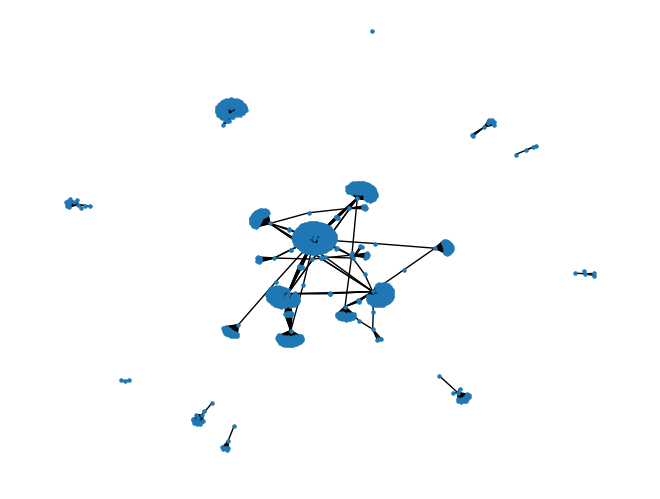

In [311]:
nx.draw(G, node_size=5)

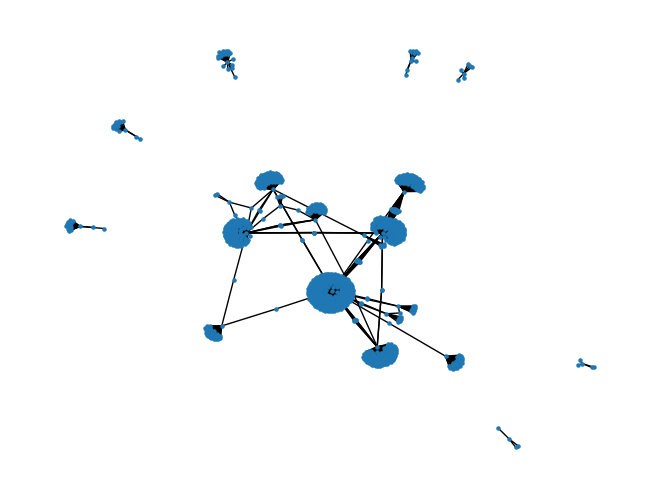

In [306]:
nx.draw(G, node_size=5)

In [243]:
df_pp.head()

,Gene 1,Gene 2
0,114787,375519
1,114787,285613
2,114787,7448
3,114787,4914
4,114787,51343


In [256]:
paths = nx.shortest_path(G, source=1559)

In [259]:
paths

{1559: [1559],
 1544: [1559, 1544],
 1543: [1559, 1543],
 6776: [1559, 6776],
 8529: [1559, 8529],
 2180: [1559, 2180],
 239: [1559, 239],
 113612: [1559, 113612],
 5076: [1559, 5076],
 1579: [1559, 1579],
 1577: [1559, 1577],
 54658: [1559, 54658],
 5243: [1559, 5243],
 216: [1559, 216],
 240: [1559, 240],
 495: [1559, 495],
 316: [1559, 316],
 119391: [1559, 119391],
 10452: [1559, 10452],
 1666: [1559, 1666],
 10599: [1559, 10599],
 9446: [1559, 9446],
 79799: [1559, 79799],
 391013: [1559, 391013],
 8398: [1559, 8398],
 8399: [1559, 8399],
 3195: [1559, 3195],
 479: [1559, 479],
 79001: [1559, 79001],
 4259: [1559, 4259],
 4258: [1559, 4258],
 4257: [1559, 4257],
 2052: [1559, 2052],
 84647: [1559, 84647],
 54600: [1559, 54600],
 50487: [1559, 50487],
 9360: [1559, 9360],
 5742: [1559, 5742],
 5743: [1559, 5743],
 80221: [1559, 80221],
 81579: [1559, 81579],
 2327: [1559, 2327],
 2326: [1559, 2326],
 2329: [1559, 2329],
 2328: [1559, 2328],
 2155: [1559, 2155],
 9685: [1559, 9685],

In [270]:
len(set(df_pp['Gene 1'].unique()).union(set(df_pp['Gene 2'].unique())).union(df_dt.Gene).union(df_dt.STITCH).union(
    df_drug_drug.chemical_a).union(df_drug_drug.chemical_b))


20887

In [266]:
df_drug_drug

,chemical_a,chemical_b
0,DB00862,DB00966
1,DB00575,DB00806
2,DB01242,DB08893
3,DB01151,DB08883
4,DB01235,DB01275
...,...,...
48509,DB00542,DB01354
48510,DB00476,DB01239
48511,DB00621,DB01120
48512,DB00808,DB01356


In [258]:
for k, lst in paths.items():
    if not len(lst):
        print(k)

In [244]:
from networkx.algorithms import tournament
dt_genes = df_dt.Gene.unique()
tournament.is_reachable(G, 114787, 375519)

NetworkXNotImplemented: not implemented for undirected type

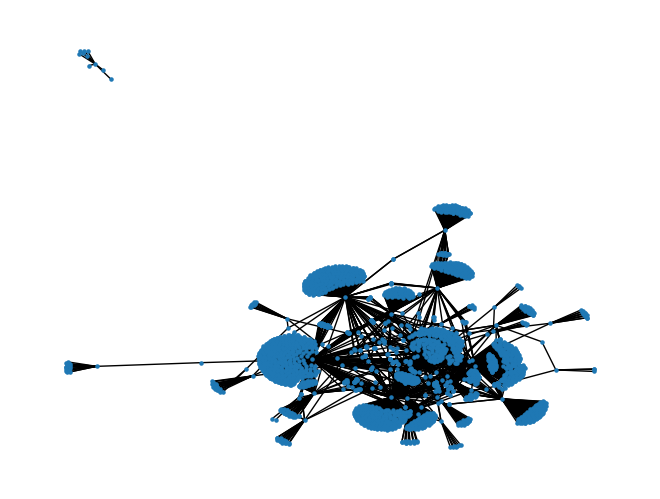

In [261]:
G = nx.Graph()
G.add_edges_from(list(df_pp.head(3000).itertuples(index=False, name=None)))
nx.draw(G, node_size=5)

In [263]:
(17500*17500)-6000000000

-5693750000

In [192]:
df_pp[(df_pp['Gene 1']==114787)|(df_pp['Gene 2']==114787)]

,Gene 1,Gene 2
0,114787,375519
1,114787,285613
2,114787,7448
3,114787,4914
4,114787,51343
5,114787,8089
6,114787,2775
7,114787,3184
8,114787,29785
9,114787,2781


In [166]:
df_pp['Gene 2'].unique().shape

(17472,)

In [155]:
df_drug_drug.chemical_a.unique().shape

(1317,)

In [145]:
# list(df_dt.itertuples(index=False, name=None))
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 3.1 MB/s eta 0:00:00m eta 0:00:010:00:01m


In [129]:
df = df.drop_duplicates(subset=['DrugbankID', 'CID'], keep='first')

In [126]:
df_dt.STITCH.unique().shape

(284,)

In [128]:
df_drug_drug.chemical_a.unique().shape

(1317,)

In [102]:
df_dt.shape

(18690, 2)

In [101]:
len(set(df_pp['Gene 2'].unique()).intersection(df_dt.Gene.unique()))

3432

In [168]:
df_pp

,Gene 1,Gene 2
0,114787,375519
1,114787,285613
2,114787,7448
3,114787,4914
4,114787,51343
...,...,...
715607,5634,5636
715608,5635,5636
715609,5635,5631
715610,5636,5631


In [119]:
len(set(df_dt['STITCH']).difference(df.CID))

43

In [97]:
df_dt      #DB00938   5152

,STITCH,Gene
0,CID000003488,1559
1,CID000003488,8647
2,CID000077992,3351
3,CID000077992,3350
4,CID000077992,3352
...,...,...
18685,CID000005152,8484
18686,CID000005152,81491
18687,CID000005152,83551
18688,CID000005152,680


In [109]:
df_drug_drug

,chemical_a,chemical_b
0,DB00862,DB00966
1,DB00575,DB00806
2,DB01242,DB08893
3,DB01151,DB08883
4,DB01235,DB01275
...,...,...
48509,DB00542,DB01354
48510,DB00476,DB01239
48511,DB00621,DB01120
48512,DB00808,DB01356


In [108]:
df_drug_target

,# Drug,Gene
0,"CID000060752,3757",NaN
1,"CID006918155,2908",NaN
2,"CID103052762,3359",NaN
3,"CID023668479,1230",NaN
4,"CID000028864,1269",NaN
...,...,...
131029,"CID000092721,3426",NaN
131030,"CID000092721,8858",NaN
131031,"CID000092721,10942",NaN
131032,"CID100115355,3242",NaN


In [83]:
df_drug_target = pd.read_csv('../data/ChG-InterDecagon_targets.csv.gz', sep='\t')
df_gene_protein = pd.read_csv('../data/GP-Miner_miner-gene-protein.tsv', sep='\t')
df_protein_protein = pd.read_csv('../data/PP-Decagon_ppi.csv.gz', sep='\t')
df_drug_target
df_gene_protein

,# Gene,Protein
0,ENSG00000198888,ENSP00000354687
1,ENSG00000198763,ENSP00000355046
2,ENSG00000198804,ENSP00000354499
3,ENSG00000198712,ENSP00000354876
4,ENSG00000228253,ENSP00000355265
...,...,...
102445,ENSG00000282892,ENSP00000489099
102446,ENSG00000282892,ENSP00000489383
102447,ENSG00000282892,ENSP00000488932
102448,ENSG00000282981,ENSP00000488999


In [92]:
df_drug_drug

,chemical_a,chemical_b
0,DB00862,DB00966
1,DB00575,DB00806
2,DB01242,DB08893
3,DB01151,DB08883
4,DB01235,DB01275
...,...,...
48509,DB00542,DB01354
48510,DB00476,DB01239
48511,DB00621,DB01120
48512,DB00808,DB01356


In [91]:
df_gene_protein

,# Gene,Protein
0,ENSG00000198888,ENSP00000354687
1,ENSG00000198763,ENSP00000355046
2,ENSG00000198804,ENSP00000354499
3,ENSG00000198712,ENSP00000354876
4,ENSG00000228253,ENSP00000355265
...,...,...
102445,ENSG00000282892,ENSP00000489099
102446,ENSG00000282892,ENSP00000489383
102447,ENSG00000282892,ENSP00000488932
102448,ENSG00000282981,ENSP00000488999


In [89]:
df_drug_target

,# Drug,Gene
0,"CID000060752,3757",NaN
1,"CID006918155,2908",NaN
2,"CID103052762,3359",NaN
3,"CID023668479,1230",NaN
4,"CID000028864,1269",NaN
...,...,...
131029,"CID000092721,3426",NaN
131030,"CID000092721,8858",NaN
131031,"CID000092721,10942",NaN
131032,"CID100115355,3242",NaN


In [90]:
df_drug_drug

,chemical_a,chemical_b
0,DB00862,DB00966
1,DB00575,DB00806
2,DB01242,DB08893
3,DB01151,DB08883
4,DB01235,DB01275
...,...,...
48509,DB00542,DB01354
48510,DB00476,DB01239
48511,DB00621,DB01120
48512,DB00808,DB01356


In [85]:
df_protein_protein 

,"114787,375519"
0,"114787,285613"
1,"114787,7448"
2,"114787,4914"
3,"114787,51343"
4,"114787,8089"
...,...
715606,"5634,5636"
715607,"5635,5636"
715608,"5635,5631"
715609,"5636,5631"


In [76]:
df_drug_target

,# Drug,Gene
0,"CID000060752,3757",NaN
1,"CID006918155,2908",NaN
2,"CID103052762,3359",NaN
3,"CID023668479,1230",NaN
4,"CID000028864,1269",NaN
...,...,...
131029,"CID000092721,3426",NaN
131030,"CID000092721,8858",NaN
131031,"CID000092721,10942",NaN
131032,"CID100115355,3242",NaN


In [74]:
df_drug_drug

,chemical_a,chemical_b
0,DB00862,DB00966
1,DB00575,DB00806
2,DB01242,DB08893
3,DB01151,DB08883
4,DB01235,DB01275
...,...,...
48509,DB00542,DB01354
48510,DB00476,DB01239
48511,DB00621,DB01120
48512,DB00808,DB01356


In [61]:
df_disease_disease[df_disease_disease['# Disease(DOID)'].str.contains('5923')]

,# Disease(DOID),Disease(DOID)
5322,DOID:5923,DOID:4897


In [65]:
df_disease_drug[df_disease_drug['# Disease MESH_ID'].str.contains('4897')]

,# Disease MESH_ID,chemical
8462,MESH:D014897,DB00479
40578,MESH:D014897,DB04528
52784,MESH:D014897,DB02587
83485,MESH:D014897,DB00470
127413,MESH:D014897,DB00316
158749,MESH:D014897,DB00515
168016,MESH:D014897,DB00499
210529,MESH:D014897,DB04690
261737,MESH:D014897,DB00684
318286,MESH:D014897,DB00313


In [44]:
df_disease_drug

,# Disease MESH_ID,Chemical
0,MESH:D005923,DB00564
1,MESH:D009503,DB01072
2,MESH:D016115,DB01759
3,MESH:D018476,DB00451
4,MESH:C567059,DB00641
...,...,...
466652,MESH:C565545,DB00482
466653,MESH:D009164,DB00977
466654,MESH:D010518,DB04216
466655,MESH:D002653,DB02701


In [36]:
df_disease_entity.head()

,# MESH_ID,Name,Definitions,Synonyms
0,MESH:C538288,10p Deletion Syndrome (Partial),NaN,"Chromosome 10, 10p- Partial|Chromosome 10, mon..."
1,MESH:C535484,13q deletion syndrome,NaN,Chromosome 13q deletion|Chromosome 13q deletio...
2,MESH:C579849,15q24 Microdeletion,NaN,15q24 Deletion|15q24 Microdeletion Syndrome|In...
3,MESH:C579850,16p11.2 Deletion Syndrome,NaN,NaN
4,MESH:C567076,"17,20-Lyase Deficiency, Isolated",NaN,"17-Alpha-Hydroxylase-17,20-Lyase Deficiency, C..."


In [41]:
df_disease_entity[df_disease_entity['# MESH_ID'].str.contains('MESH:D005923')]

,# MESH_ID,Name,Definitions,Synonyms
4454,MESH:D005923,"Glomerulosclerosis, Focal Segmental",A clinicopathological syndrome or diagnostic t...,Focal Glomerulosclerosis|Focal Sclerosing Glom...


In [47]:
MID = '# Disease MESH_ID'
len(set(df_disease_entity[MID].unique()).intersection(df_disease_drug[MID].unique()))

5165

In [49]:
df_disease_entity[]

(5536,)